# **Reto-> Entrega 2**

### **Maestría en Inteligencia Artificial Aplicada**
### **Curso: Ciencia y Analítica de Datos**
### **Tecnológico de Monterrey**
### **Prof María de la Paz Rico Fernández**

### **Equipo 14**

### **Nombre de los estudiantes**: 
- **Alejandro García Hernández - A01793812**
- **Francisco Javier Morales Jimenez - A01794339**

#Base de aguas subterraneas

- Selecciona tus variables independientes X y dependiente Y (semáforo)
- Cambia a label encoding el semáforo, ej, de ["clase 1", "clase 2", "clase 3"] a [ 1,2,3]
- Realiza un análisis general de las features importances a traves de decision trees o random forest.
- Selecciona las variables de mayor importancia.
- Realiza tu clasificador, recuerda dividir los datos de manera balanceada (auxiliate de train test split)
- Explora que clasificador es el más optimo, ejemplo:
 - Decision trees
 - Random Forest.
- Determina el grado de exactitud a través del reporte de clasificación y análisis de la gráfica de Precision Recall.
- Visualiza los resultados del modelo o las predicciones a través de una matriz de confusión.

In [45]:
#librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import concat

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize, OneHotEncoder

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve, plot_precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

from yellowbrick.classifier import PrecisionRecallCurve


In [3]:
#se descargan los datos y se observan los primeros 3 regiustros
path = "https://raw.githubusercontent.com/PosgradoMNA/actividades-de-aprendizaje-algaher0805/main/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv"
df = pd.read_csv(path,encoding='latin-1')

df.head(3)

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

Observamos que en general los valores faltantes son pocos a excepción de la variable SDT_mg/L que de hecho no contiene información y también CONTAMINANTES que tiene alrededor de 40% de datos faltantes, sin embargo, en esta última tiene sentido que haya valores vacios lo cuál significa que no existe ningún contaminante (se podrían reemplazan los missing por "sin").

Por otro lado, existen diferentes indicadores para la calidad del agua, y para cada uno de estos indicadores la base contiene dos variables, una categótica y una númera, como la información contenida es la misma, para el presente ejercicio se omitirán las variables categóricas. Cabe señalar, que las variables que se tomarán en consideración son de tipo object porque algunos de sus valores hacen referencia a valores menores a cierto nivel, estos fueron registrados con el simbolo "<" por lo que habrá que sustituir estos valores por un valor númerico.

In [5]:
#Como una primer prueba simplemente asumimos que el valor de cada uno de los registros que contiene el signo "<" es exactamente al valor de esa desigualdad.
# Y convertimos las varibales a numéricas  

Xy =  df [["ALC_mg/L", "CONDUCT_mS/cm", "FLUORUROS_mg/L", "DUR_mg/L", "COLI_FEC_NMP/100_mL", "N_NO3_mg/L", "AS_TOT_mg/L", "CD_TOT_mg/L","CR_TOT_mg/L",
"HG_TOT_mg/L", "PB_TOT_mg/L", "MN_TOT_mg/L", "FE_TOT_mg/L", "SEMAFORO"]]

variables = ["FLUORUROS_mg/L", "DUR_mg/L", "COLI_FEC_NMP/100_mL", "N_NO3_mg/L", "AS_TOT_mg/L", "CD_TOT_mg/L","CR_TOT_mg/L",
"HG_TOT_mg/L", "PB_TOT_mg/L", "MN_TOT_mg/L", "FE_TOT_mg/L"]

for i in variables:
  Xy[i] = Xy[i].str.replace('<', '0').astype('float64')

le = LabelEncoder()
le.fit(Xy["SEMAFORO"])
Xy["SEMAFORO"] = le.transform(Xy["SEMAFORO"]).astype('float64')

#Eliminamos los missing
Xy = Xy.dropna()

#Obtenemos estadísticas básicas de cada variable
Xy.describe()

#Xy.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,ALC_mg/L,CONDUCT_mS/cm,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L,SEMAFORO
count,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000
mean,234.505720,1142.262027,1.077197,349.670588,359.210985,4.330137,0.019486,0.003030,0.013337,0.000557,0.005285,0.072849,0.412255,1.171402
std,111.133345,1247.971184,1.929627,360.709353,2063.783603,8.379416,0.035020,0.000899,0.155265,0.000469,0.003273,0.378506,5.569045,0.780069
min,26.640000,110.000000,0.200000,20.000000,1.100000,0.020000,0.010000,0.003000,0.005000,0.000500,0.005000,0.001500,0.025000,0.000000
25%,164.048750,505.500000,0.269225,121.512000,1.100000,0.651860,0.010000,0.003000,0.005000,0.000500,0.005000,0.001500,0.025000,1.000000
50%,215.767500,820.000000,0.505450,245.994450,1.100000,2.082916,0.010000,0.003000,0.005000,0.000500,0.005000,0.001500,0.046900,1.000000
75%,292.710000,1328.000000,1.140800,455.051600,13.250000,5.194454,0.010000,0.003000,0.005000,0.000500,0.005000,0.009848,0.173380,2.000000
max,1650.000000,18577.000000,34.803300,3810.692200,24196.000000,121.007813,0.452200,0.032110,5.003200,0.014150,0.080900,8.982000,178.615000,2.000000


In [6]:
#Esto es solo para saber como quedó codificada nuestra variable dependiente.
pd.DataFrame({
    "original": df["SEMAFORO"].unique(),
    "codificada": Xy["SEMAFORO"].unique()
})


,original,codificada
0,Verde,2.0
1,Rojo,1.0
2,Amarillo,0.0


In [58]:
#Definimos los conjuntos de variables independientes y la variable objetivo será la variable semáforo.
X = Xy [["ALC_mg/L", "CONDUCT_mS/cm", "FLUORUROS_mg/L", "DUR_mg/L", "COLI_FEC_NMP/100_mL", "N_NO3_mg/L", "AS_TOT_mg/L", "CD_TOT_mg/L","CR_TOT_mg/L",
"HG_TOT_mg/L", "PB_TOT_mg/L", "MN_TOT_mg/L", "FE_TOT_mg/L"]]

y = Xy["SEMAFORO"]

In [59]:
#Para evitar el data leakage primero definimos un conjunto de entrenamiento sobre el que haremos el análisis de calidad de la base
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Ahora observamos la distribución de las variables así como posibles valores atípicos.

Ingresar variables correlacionadas puede mermar el rendimiento de nuestro modelo, por tal motivo es importante observar si algunas de las variables están correlacionadas

In [60]:
# función para crear un boxplot y un histograma en la misma escala.

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    # Se crean 2 subgráficas

    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="violet")
    # El boxplot se crea e indica el valor de la media de la columna

    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2)
    # histograma

    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--")
    # Agrega la media al histograma

    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")

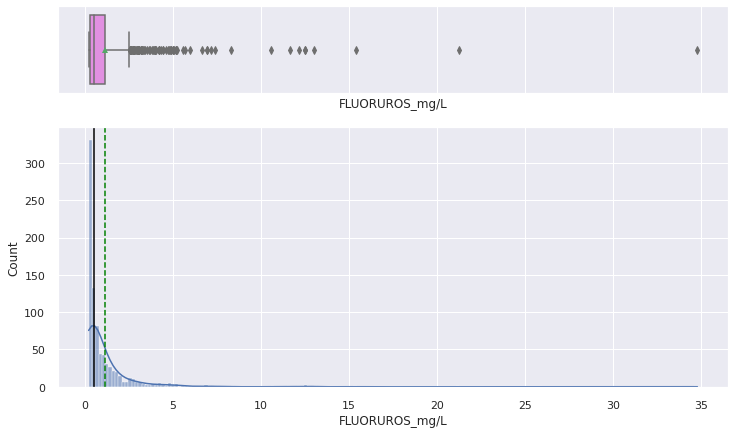

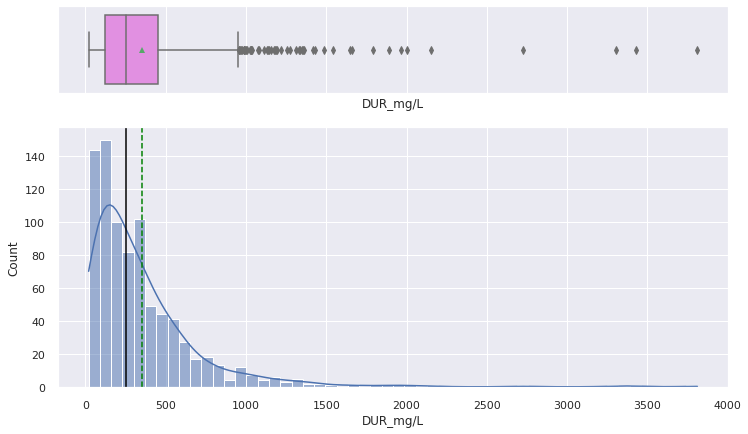

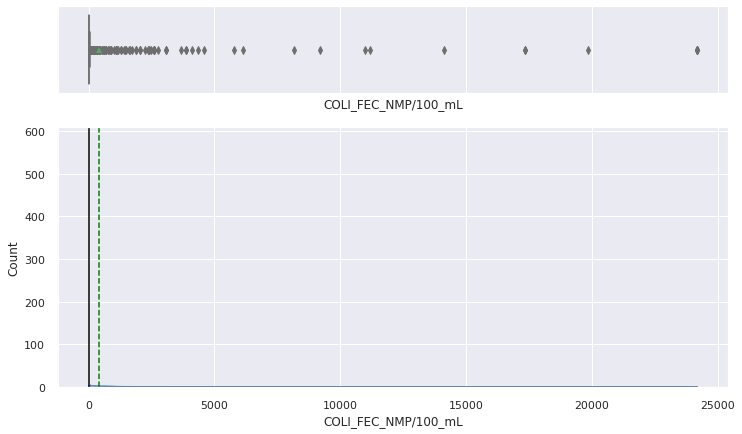

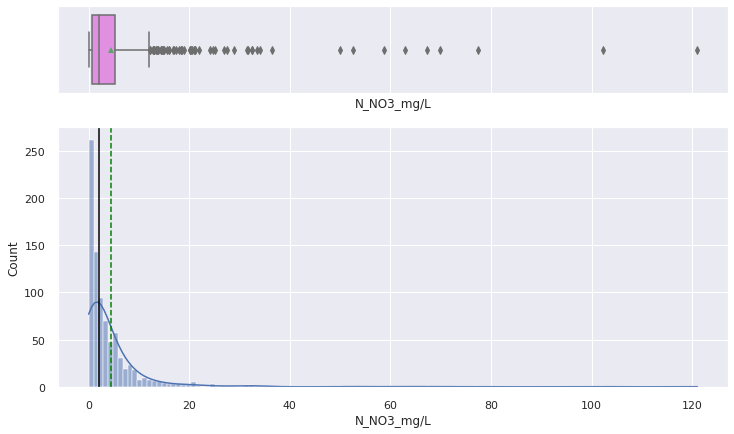

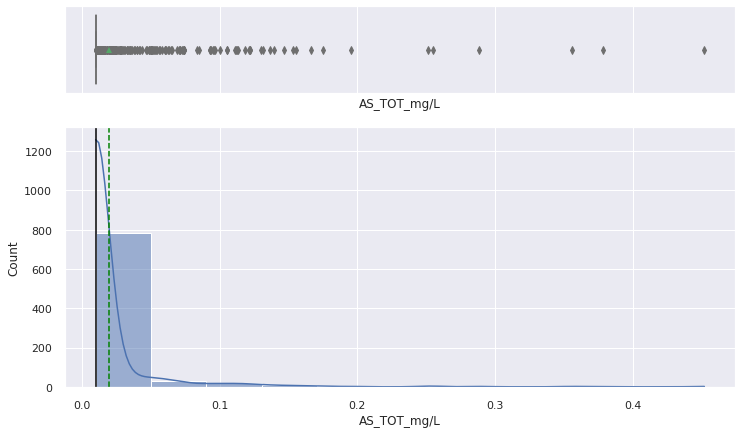

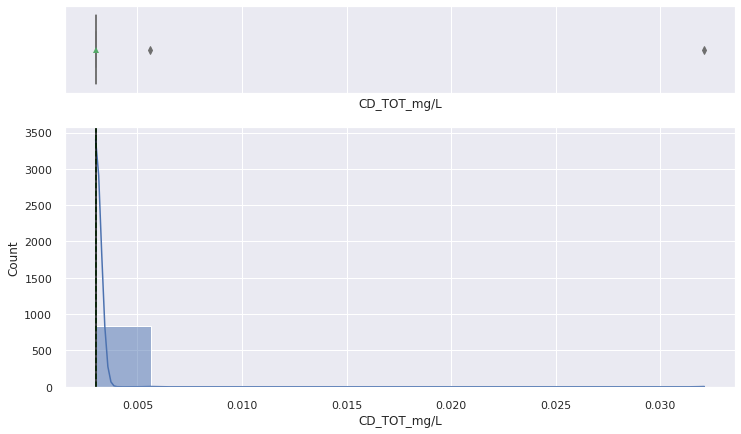

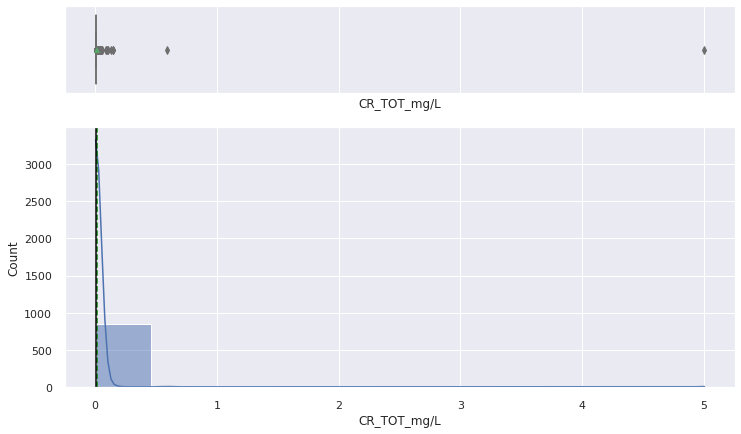

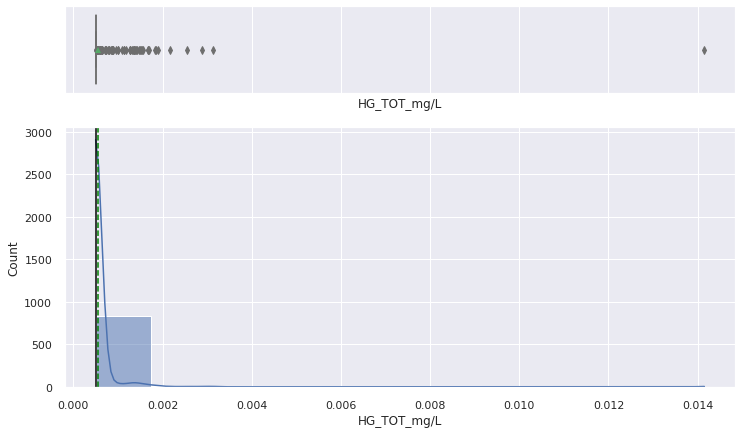

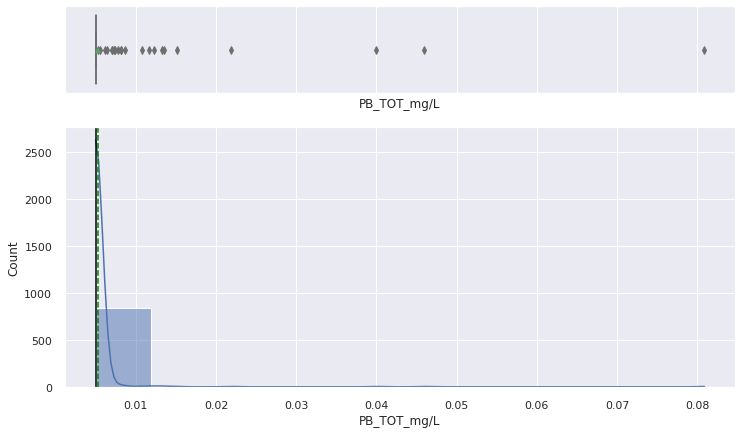

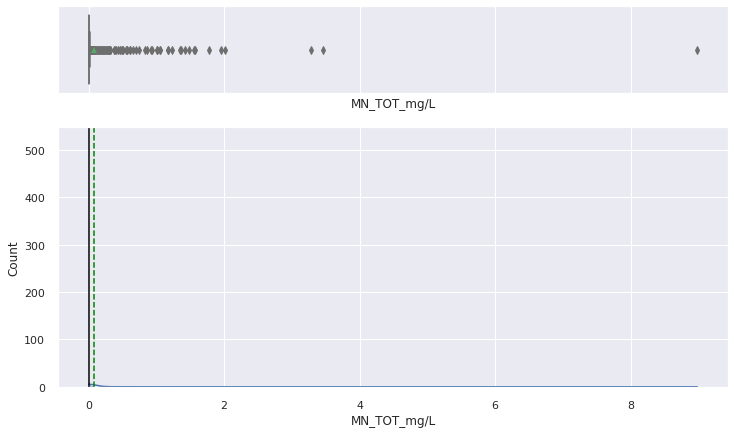

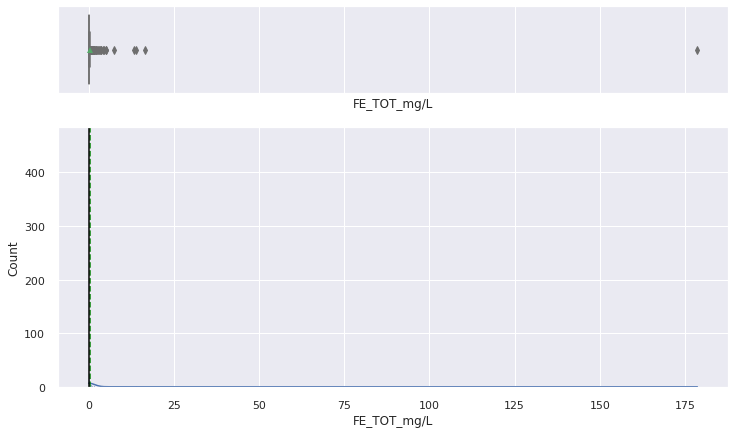

In [61]:
# Crea gráficos de distribución de las variables numéricas
for n in variables:
    histogram_boxplot(data=x_train, feature=n, kde=True)

Como se observa en la tabla de estadísticos así como en las gráficas de distribuciones, la variable CD_TOT_mg/L contiene un solo valor para todos los registros excepto para dos, por lo que esta variable no aporta nada de información y debe de quitarse. Además, de entrada parecería que el resto de las variables contienen valores atípicos, sin embargo, al comprender la naturaleza de los mismos, tiene sentido que la mayoría de los valores indiquen que no hay contaminación del agua, por lo que la mayoría de los registros deberían estár agrupados por debajo de cierto valor, es decir lo que parecen datos atípicos en realidad podrían ser los valores que nos indiquen contaminación. Por lo tanto no se deben de quitar los valores atípicos. 

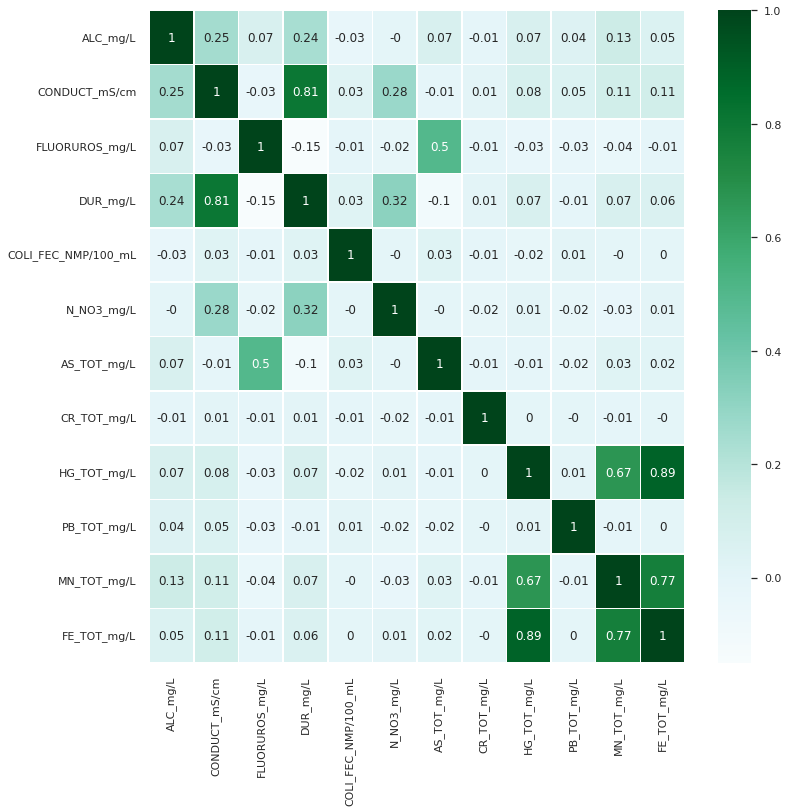

In [62]:
#Primero se elimina la variable CD_TOT_mg/L de los conjuntos de entrenamiento y prueba
x_train = x_train.drop(['CD_TOT_mg/L'], axis=1)
x_test = x_test.drop(['CD_TOT_mg/L'], axis=1)

#Observamos si existe correlación entre las variables que se planean usar en el modelo
sns.set(rc={'figure.figsize':(12,12)}) 
sns.heatmap(round(x_train.corr(),2), annot = True, cmap= 'BuGn', linewidths= 0.5)
plt.show()

Como se observa en la imagen anterior, hay 5 variables que guardan al menos una correlación importante con alguna de ellas. Se realiza entonces un análisis de componentes principales con estas 5 variables con la finalidad de reducir la dimensionalidad de la base además de que las variables que se ingresen al modelo no estén correlacionadas entre ellas.

In [63]:
#Nos quedamos con las variables que están correlacionadas y las estandarizamos 
df_pca = x_train[["CONDUCT_mS/cm", "DUR_mg/L","HG_TOT_mg/L", "MN_TOT_mg/L", "FE_TOT_mg/L"]]

scaler = StandardScaler()
scaler.fit(df_pca)
df_pca = scaler.transform(df_pca)

In [64]:
#se estimarán solo 2 componente
pca = PCA(n_components=2) 
df_pca2 = pca.fit_transform(df_pca) 

#PAra observar la cantidad de variación original capturada por los componentes calculados
print(pca.explained_variance_ratio_)


[0.52189566 0.35236182]


Se observa que el primer componente captura alrededor del 52% de la varianza original de los datos y la segunda componente 35%, es decir, en total estas dos componentes capturan alrededor del 87% de la variación original de las 5 variables.

In [65]:
#Para saber si ambas variables son importantes en el componente
print(abs( pca.components_ ))


[[0.18599654 0.16542787 0.56074698 0.53302478 0.58265454]
 [0.68088196 0.68887369 0.15035048 0.12714282 0.15192836]]


- Se observa que "HG_TOT_mg/L", "MN_TOT_mg/L" y "FE_TOT_mg/L" son las variables más importantes para el primer componente.

- Por otro lado, "CONDUCT_mS/cm" y "DUR_mg/L" son las variables más importantes para la segunda componente.

Ahora si, se sustituyen estas dos componente por las 5 variables correlacionadas y se entrena un árbol de decisión.

In [66]:
#Se contruye la base que se usará para las estimaciones

x_train = x_train [["ALC_mg/L", "FLUORUROS_mg/L", "COLI_FEC_NMP/100_mL", "N_NO3_mg/L", "AS_TOT_mg/L","CR_TOT_mg/L", "PB_TOT_mg/L"]]

df_pca2 = pd.DataFrame(df_pca2).reset_index(drop=True)
x_train = pd.concat([x_train.reset_index(drop=True),df_pca2.reset_index(drop=True)], axis=1)
x_train.columns = ["ALC_mg/L", "FLUORUROS_mg/L", "COLI_FEC_NMP/100_mL", "N_NO3_mg/L", "AS_TOT_mg/L","CR_TOT_mg/L", "PB_TOT_mg/L", "PC1", "PC2"]
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ALC_mg/L             844 non-null    float64
 1   FLUORUROS_mg/L       844 non-null    float64
 2   COLI_FEC_NMP/100_mL  844 non-null    float64
 3   N_NO3_mg/L           844 non-null    float64
 4   AS_TOT_mg/L          844 non-null    float64
 5   CR_TOT_mg/L          844 non-null    float64
 6   PB_TOT_mg/L          844 non-null    float64
 7   PC1                  844 non-null    float64
 8   PC2                  844 non-null    float64
dtypes: float64(9)
memory usage: 59.5 KB


In [67]:
#Entrenaremos primero un árbol con una profundidad de 3
modelo = DecisionTreeClassifier(max_depth=3, random_state=42)
modelo.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

Profundidad del árbol: 3
Número de nodos terminales: 5


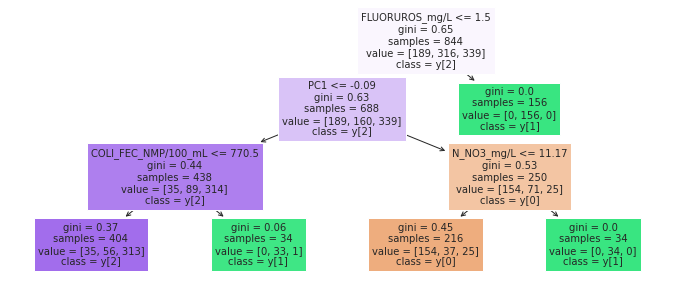

In [68]:
# Ahora podemos observar el árbol resultante
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

nombres=["Mood1", "Mood2", "Mood3"]

plot = plot_tree(
            decision_tree = modelo,
            feature_names = x_train.columns,
            class_names=True,
            filled        = True,
            impurity      = True,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

Se observa que con una profundidad de 3, el árbol comienza a separar bastante bastante bien a los registros con semáforo rojo (recordando la codificación que se realizó: amarillo = 0, rojo = 1, verde = 2). Sin embargo, la impuresa del resto de los nodos finales es alta. Con el objetivo de mejorar el modelo se realiza la busqueda de los mejores parámetros.

In [69]:
#Para evaluar el modelo realizamos el mismo tratamiento que al conjunto de entrenamiento

df_pca_test = x_test[["CONDUCT_mS/cm", "DUR_mg/L","HG_TOT_mg/L", "MN_TOT_mg/L", "FE_TOT_mg/L"]]

scaler = StandardScaler()
scaler.fit(df_pca_test)
df_pca_test = scaler.transform(df_pca_test)

pca_test = PCA(n_components=2) 
df_pca2_test = pca_test.fit_transform(df_pca_test) 

x_test = x_test [["ALC_mg/L", "FLUORUROS_mg/L", "COLI_FEC_NMP/100_mL", "N_NO3_mg/L", "AS_TOT_mg/L","CR_TOT_mg/L", "PB_TOT_mg/L"]]

df_pca2_test = pd.DataFrame(df_pca2_test).reset_index(drop=True)
x_test = pd.concat([x_test.reset_index(drop=True),df_pca2_test.reset_index(drop=True)], axis=1)
x_test.columns = ["ALC_mg/L", "FLUORUROS_mg/L", "COLI_FEC_NMP/100_mL", "N_NO3_mg/L", "AS_TOT_mg/L","CR_TOT_mg/L", "PB_TOT_mg/L", "PC1", "PC2"]
x_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ALC_mg/L             212 non-null    float64
 1   FLUORUROS_mg/L       212 non-null    float64
 2   COLI_FEC_NMP/100_mL  212 non-null    float64
 3   N_NO3_mg/L           212 non-null    float64
 4   AS_TOT_mg/L          212 non-null    float64
 5   CR_TOT_mg/L          212 non-null    float64
 6   PB_TOT_mg/L          212 non-null    float64
 7   PC1                  212 non-null    float64
 8   PC2                  212 non-null    float64
dtypes: float64(9)
memory usage: 15.0 KB


In [70]:
#Para medir la exactitud del modelo
y_hat = modelo.predict(x_test)

accuracy = accuracy_score(y_test,y_hat)
print(f"El accuracy de test es: {round(accuracy*100,1)} %")

El accuracy de test es: 84.4 %


In [71]:
#original	codificada
#0	Verde	2.0
#1	Rojo	1.0
#2	Amarillo	0.0

In [72]:
#para obtener los mejores parámetros

parametros = {'criterion':['gini','entropy'],'max_depth': np.arange(3, 10)}
modelo=DecisionTreeClassifier(min_samples_leaf=5,random_state=42)
#Se usarán también validación cruzada dividiendo el conjunto de entrenamiento en 5
grid_dtree = GridSearchCV(modelo, parametros, cv=5, scoring = "accuracy")
grid_dtree.fit(x_train, y_train)
grid_dtree.best_params_

{'criterion': 'entropy', 'max_depth': 9}

In [90]:
y_hat = grid_dtree.predict(x_test)
accuracy = accuracy_score(y_test,y_hat)
print(f"El accuracy de modelo con los mejores parámetros es: {round(accuracy*100,1)} %")

El accuracy de modelo con los mejores parámetros es: 91.0 %


Como podemos observar se logró mejorar el rendimieto del modelo y como se muestra en la tabla de abajo, 5 variables son los predictores más importantes, por lo que si la base fuera muy grande podrían omitirse las 4 restantes (que acumulan alrededor del 15% del poder de predicción.

<function matplotlib.pyplot.show(*args, **kw)>

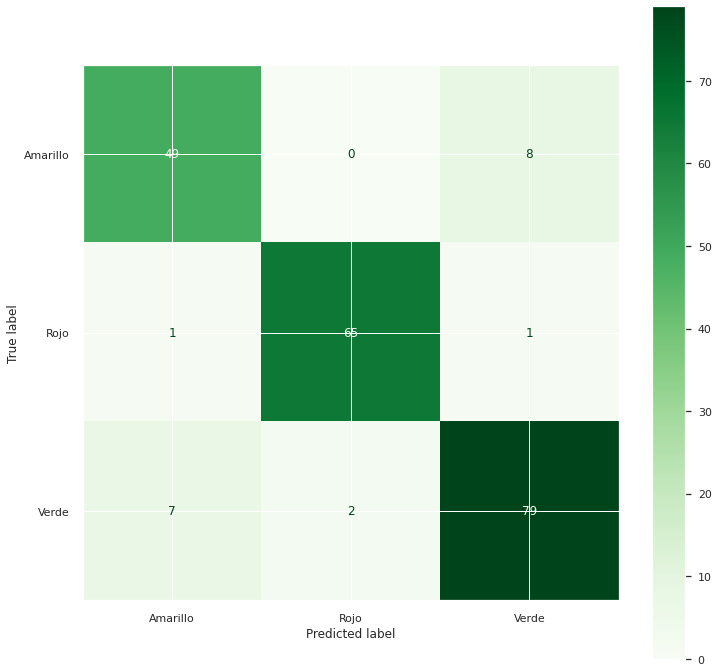

In [74]:
#Se grafica la matriz de confusión
mc = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(mc, display_labels=["Amarillo","Rojo","Verde"])
disp = disp.plot(cmap=plt.cm.Greens,values_format='g')
plt.show

In [75]:
# Definición de función de Precision
def mi_precision(yreal, ypred):

    mc = confusion_matrix(yreal, ypred)

    #Para la categoria 0 (amarillo)
    VP_0 = mc[0][0]
    FP_0 = mc[1][0] + mc[2][0]
    VN_0 = mc[1][1] + mc[1][2] + mc[2][1] + mc[2][2]
    FN_0 = mc[0][1] + mc[0][2]

    #Para la categoria 1 (rojo)
    VP_1 = mc[1][1]
    FP_1 = mc[0][1] + mc[2][1]
    VN_1 = mc[0][0] + mc[0][2] + mc[2][0] + mc[2][2]
    FN_1 = mc[1][0] + mc[1][2]

    #Para la categoria 2 (verde)
    VP_2 = mc[2][2]
    FP_2 = mc[0][2] + mc[1][2]
    VN_2 = mc[0][0] + mc[0][1] + mc[1][0] + mc[1][1]
    FN_2 = mc[2][0] + mc[2][1]

    precision_0 = round(VP_0 / (VP_0 + FP_0),2)
    precision_1 = round(VP_1 / (VP_1 + FP_1),2)
    precision_2 = round(VP_2 / (VP_2 + FP_2),2)
    precision = [precision_0, precision_1, precision_2]

    return precision


#########################################################################

# Definición de función de Recall
def mi_recall(yreal, ypred):

    mc = confusion_matrix(yreal, ypred)

    #Para la categoria 0 (amarillo)
    VP_0 = mc[0][0]
    FP_0 = mc[1][0] + mc[2][0]
    VN_0 = mc[1][1] + mc[1][2] + mc[2][1] + mc[2][2]
    FN_0 = mc[0][1] + mc[0][2]

    #Para la categoria 1 (rojo)
    VP_1 = mc[1][1]
    FP_1 = mc[0][1] + mc[2][1]
    VN_1 = mc[0][0] + mc[0][2] + mc[2][0] + mc[2][2]
    FN_1 = mc[1][0] + mc[1][2]

    #Para la categoria 2 (verde)
    VP_2 = mc[2][2]
    FP_2 = mc[0][2] + mc[1][2]
    VN_2 = mc[0][0] + mc[0][1] + mc[1][0] + mc[1][1]
    FN_2 = mc[2][0] + mc[2][1]

    recall_0 = round(VP_0 / (VP_0 + FN_0),2)
    recall_1 = round(VP_1 / (VP_1 + FN_1),2)
    recall_2 = round(VP_2 / (VP_2 + FN_2),2)
    recall = [recall_0, recall_1, recall_2]

    return recall

#########################################################################

In [76]:
for i in range (0,3):
  print("La precisión para la clase ",str(i), "es: ",mi_precision(y_test, y_hat)[i])
  print("El recall para la clase ",str(i), "es: ",mi_recall(y_test, y_hat)[i])

La precisión para la clase  0 es:  0.86
El recall para la clase  0 es:  0.86
La precisión para la clase  1 es:  0.97
El recall para la clase  1 es:  0.97
La precisión para la clase  2 es:  0.9
El recall para la clase  2 es:  0.9


In [91]:
#También se pueden calcular estas mismas variables y algunas adicionales con la función classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        57
         1.0       0.97      0.97      0.97        67
         2.0       0.90      0.90      0.90        88

    accuracy                           0.91       212
   macro avg       0.91      0.91      0.91       212
weighted avg       0.91      0.91      0.91       212



In [77]:
modelobis = DecisionTreeClassifier(min_samples_leaf=5, max_depth=9, random_state=42, criterion="entropy")
modelobis.fit(x_train,y_train)

importancia = pd.DataFrame({'variable': x_train.columns,
                            'importancia': modelobis.feature_importances_*100}
                            ).sort_values('importancia', ascending=False)
importancia

,variable,importancia
1,FLUORUROS_mg/L,24.197859
7,PC1,21.225975
3,N_NO3_mg/L,16.889335
4,AS_TOT_mg/L,11.773677
2,COLI_FEC_NMP/100_mL,10.820039
5,CR_TOT_mg/L,4.696308
0,ALC_mg/L,4.326867
8,PC2,4.050646
6,PB_TOT_mg/L,2.019295


Finalmente obtenemos la gréfica de la curva Precisio-Recall.

/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/prcurve.py:257: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  YellowbrickWarning,


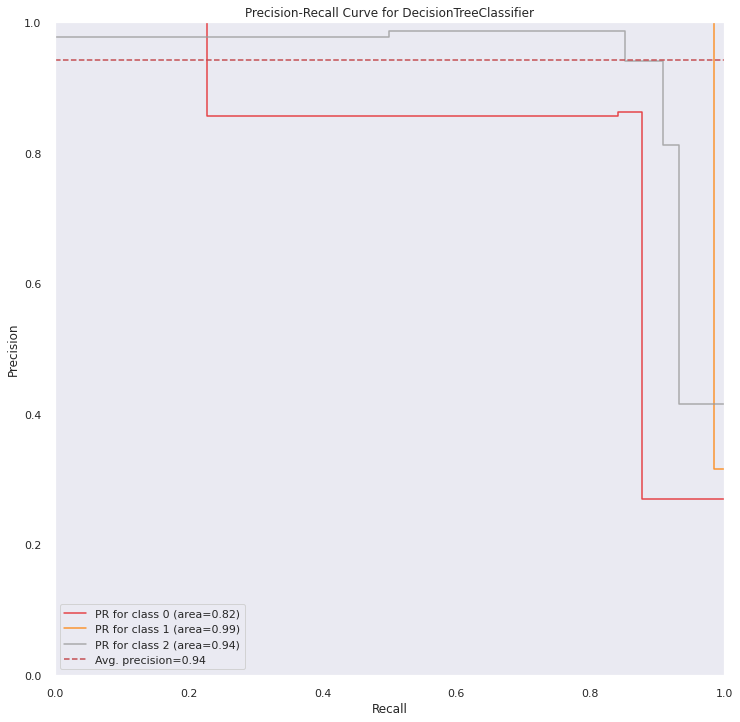

In [78]:
y_train2 = LabelEncoder().fit_transform(y_train)
y_test2 = LabelEncoder().fit_transform(y_test)

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(
    modelobis,
    per_class=True,
    cmap="Set1"
)
viz.fit(x_train, y_train2)
viz.score(x_test, y_test2)
viz.show()

# Ahora probaremos utlizando Random Forest

In [79]:
# Se crea un modelo con 20 arboles
modelo2 = RandomForestClassifier(n_estimators=20, bootstrap = True, max_depth=3, random_state=42,)
modelo2.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)

In [80]:
#Para medir la exactitud del modelo
y_hat = modelo2.predict(x_test)

accuracy = accuracy_score(y_test,y_hat)
print(f"El accuracy de test es: {round(accuracy*100,1)} %")

El accuracy de test es: 76.9 %


Parecería que se obtuvo un peor rendimiento pero podemos buscar los mejores parámetros para intentar mejorar el modelo

In [81]:
#para obtener los mejores parámetros
parametros2 = {'criterion':['gini','entropy'],'max_depth': np.arange(3, 10),'n_estimators': [50, 100, 200]}
modelo2=RandomForestClassifier(min_samples_leaf=5,random_state=42,bootstrap = True)
#Se usarán también validación cruzada dividiendo el conjunto de entrenamiento en 5
grid_RF = GridSearchCV(modelo2, parametros2, cv=5, scoring = "accuracy")
grid_RF.fit(x_train, y_train)
grid_RF.best_params_

{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 50}

In [82]:
#Para medir la exactitud del modelo
y_hat = grid_RF.predict(x_test)

accuracy = accuracy_score(y_test,y_hat)
print(f"El accuracy de test es: {round(accuracy*100,1)} %")

El accuracy de test es: 91.5 %


Ahora si observamos una mejora marginal con respecto al resultado obtenido con el árbol de decisión

Ahora se grafica la matriz de confusión

<function matplotlib.pyplot.show(*args, **kw)>

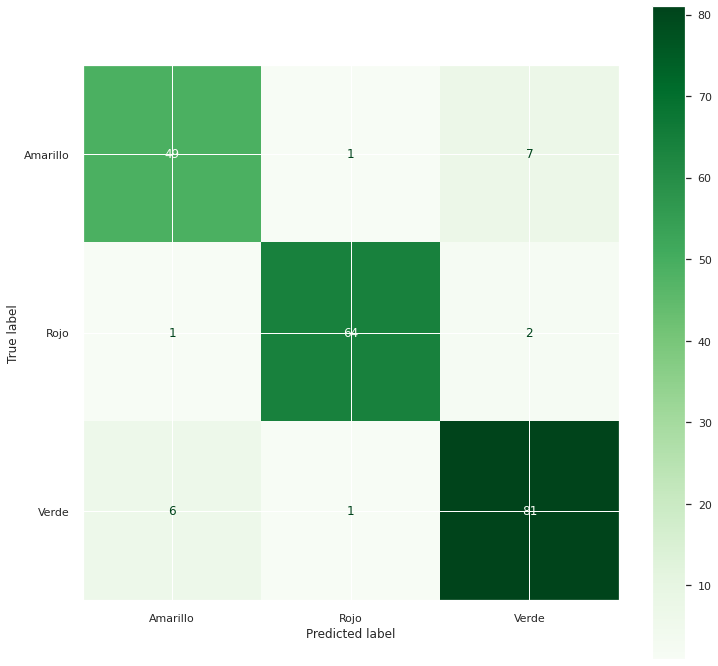

In [83]:
#Se grafica la matriz de confusión
mc = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(mc, display_labels=["Amarillo","Rojo","Verde"])
disp = disp.plot(cmap=plt.cm.Greens,values_format='g')
plt.show

In [85]:
for i in range (0,3):
  print("La precisión para la clase ",str(i), "es: ",mi_precision(y_test, y_hat)[i])
  print("El recall para la clase ",str(i), "es: ",mi_recall(y_test, y_hat)[i])

La precisión para la clase  0 es:  0.88
El recall para la clase  0 es:  0.86
La precisión para la clase  1 es:  0.97
El recall para la clase  1 es:  0.96
La precisión para la clase  2 es:  0.9
El recall para la clase  2 es:  0.92


In [86]:
#También se pueden calcular estas mismas variables y algunas adicionales con la función classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87        57
         1.0       0.97      0.96      0.96        67
         2.0       0.90      0.92      0.91        88

    accuracy                           0.92       212
   macro avg       0.91      0.91      0.91       212
weighted avg       0.92      0.92      0.92       212



In [87]:
#Para observar que variables son las más importantes para predecir
modelobis2 = RandomForestClassifier(n_estimators=50, bootstrap = True, max_depth=9, random_state=42, criterion="gini")
modelobis2.fit(x_train,y_train)

importancia = pd.DataFrame({'variable': x_train.columns,
                            'importancia': modelobis2.feature_importances_*100}
                            ).sort_values('importancia', ascending=False)
importancia

,variable,importancia
1,FLUORUROS_mg/L,25.376006
7,PC1,16.018465
3,N_NO3_mg/L,13.589386
8,PC2,12.377118
4,AS_TOT_mg/L,12.077321
2,COLI_FEC_NMP/100_mL,11.275159
0,ALC_mg/L,4.176350
5,CR_TOT_mg/L,3.416578
6,PB_TOT_mg/L,1.693617


Se observa que para el random forest algunas variables pierden relevancia en comparación con el árbol de decisión.

/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/prcurve.py:257: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  YellowbrickWarning,


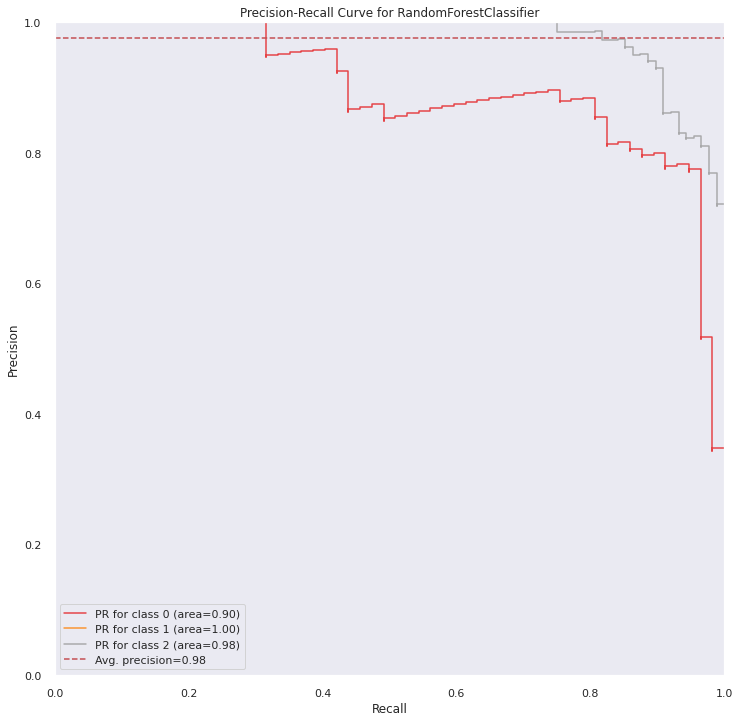

In [88]:

y_train2 = LabelEncoder().fit_transform(y_train)
y_test2 = LabelEncoder().fit_transform(y_test)

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(
    modelobis2,
    per_class=True,
    cmap="Set1"
)
viz.fit(x_train, y_train2)
viz.score(x_test, y_test2)
viz.show()

Se observa que ambos modelos tienen un buen desempeño, sin embargo, con random forest logramos un mejor desempeño. De manera individual, con la matriz de confusión se observa que el árbol de decisión tiene un mejor recall para el semáforo de color rojo que el random forest, sin embargo, al ver la curva PR se observa un mejor desempeño en general para los 3 colores de semáforo con el random forest. 